In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow.keras as tfk
from keras.models import Sequential, Model
from keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout, TimeDistributed, LSTM
from keras.callbacks import ModelCheckpoint
import tensorflow_datasets as tfds
from google.colab import drive
from tensorflow.data.experimental import sample_from_datasets

tfkl = tfk.layers

In [ ]:
drive.mount('/content/gdrive/', force_remount=True)

Mounted at /content/gdrive/


In [ ]:
file_path = "/content/gdrive/My Drive/crypto_currency_feature_selection.csv"
df = pd.read_csv(file_path, index_col=0)
df

,gold_price,close_XRP,close_ETH,close_LTC,close_EOS,close_BCH,close_BNB,close_BTC,close_XMR,volume_XRP,volume_ETH,volume_LTC,volume_EOS,volume_BCH,volume_BNB,volume_BTC,volume_XMR
0,0.120113,0.456272,0.167329,0.153754,0.451595,1.362968,0.140213,0.068876,0.401513,-0.017459,0.001281,0.003253,0.011697,0.514297,0.188704,0.001411,-0.004116
1,0.132096,0.440049,0.161164,0.144868,0.428930,1.283956,0.138502,0.057771,0.378302,-0.018223,0.001818,0.004981,0.011375,0.491524,0.194198,0.002418,0.003329
2,0.061686,0.412287,0.158826,0.127112,0.373361,1.035453,0.181891,0.059758,0.327433,-0.017784,0.000233,-0.001847,0.028857,0.382425,0.167713,0.000381,-0.026946
3,0.057625,0.419477,0.165105,0.129096,0.384465,1.066728,0.178751,0.056384,0.335247,-0.018068,0.000311,-0.002021,0.030327,0.393318,0.169680,0.000595,-0.027451
4,0.128833,0.467350,0.183652,0.154572,0.473141,1.421224,0.126568,0.051967,0.415665,-0.019956,0.000892,0.003795,0.013347,0.538045,0.200772,0.001153,0.003074
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1109,0.823508,0.192269,0.264656,0.121032,0.118081,0.386855,0.595128,0.535524,0.748867,0.122740,0.191738,0.243448,0.105914,0.074474,0.157002,0.106847,0.239369
1110,0.793989,0.189832,0.268374,0.115043,0.113979,0.370009,0.582406,0.531650,0.712260,0.128442,0.223005,0.197066,0.093786,0.083470,0.144806,0.137137,0.198603
1111,0.893333,0.208156,0.300278,0.120424,0.134320,0.423121,0.624225,0.548771,0.757467,0.232391,0.375424,0.282329,0.181169,0.220867,0.376059,0.193844,0.327400
1112,0.776638,0.183055,0.272752,0.106348,0.105783,0.342352,0.625903,0.515251,0.688669,0.294049,0.403155,0.271041,0.305128,0.282547,0.500225,0.216417,0.357276


In [ ]:
df_price = df[[e for e in df.columns if 'close' in e or 'price' in e]]
df_price.shape

(1114, 9)

In [ ]:
out = pd.DataFrame()
for i in range(df_price.shape[0] - 30):
    sub = df_price.iloc[i:(i+30), :].reset_index(drop=True)
    sub.columns = [e + "_" + str(i) for e in sub.columns]
    out = pd.concat([out, sub], axis=1)

In [ ]:
out.shape

(30, 9756)

In [ ]:
out

,gold_price_0,close_XRP_0,close_ETH_0,close_LTC_0,close_EOS_0,close_BCH_0,close_BNB_0,close_BTC_0,close_XMR_0,gold_price_1,close_XRP_1,close_ETH_1,close_LTC_1,close_EOS_1,close_BCH_1,close_BNB_1,close_BTC_1,close_XMR_1,gold_price_2,close_XRP_2,close_ETH_2,close_LTC_2,close_EOS_2,close_BCH_2,close_BNB_2,close_BTC_2,close_XMR_2,gold_price_3,close_XRP_3,close_ETH_3,close_LTC_3,close_EOS_3,close_BCH_3,close_BNB_3,close_BTC_3,close_XMR_3,gold_price_4,close_XRP_4,close_ETH_4,close_LTC_4,...,close_BCH_1079,close_BNB_1079,close_BTC_1079,close_XMR_1079,gold_price_1080,close_XRP_1080,close_ETH_1080,close_LTC_1080,close_EOS_1080,close_BCH_1080,close_BNB_1080,close_BTC_1080,close_XMR_1080,gold_price_1081,close_XRP_1081,close_ETH_1081,close_LTC_1081,close_EOS_1081,close_BCH_1081,close_BNB_1081,close_BTC_1081,close_XMR_1081,gold_price_1082,close_XRP_1082,close_ETH_1082,close_LTC_1082,close_EOS_1082,close_BCH_1082,close_BNB_1082,close_BTC_1082,close_XMR_1082,gold_price_1083,close_XRP_1083,close_ETH_1083,close_LTC_1083,close_EOS_1083,close_BCH_1083,close_BNB_1083,close_BTC_1083,close_XMR_1083
0,0.120113,0.456272,0.167329,0.153754,0.451595,1.362968,0.140213,0.068876,0.401513,0.132096,0.440049,0.161164,0.144868,0.428930,1.283956,0.138502,0.057771,0.378302,0.061686,0.412287,0.158826,0.127112,0.373361,1.035453,0.181891,0.059758,0.327433,0.057625,0.419477,0.165105,0.129096,0.384465,1.066728,0.178751,0.056384,0.335247,0.128833,0.467350,0.183652,0.154572,...,0.447231,0.515549,0.511916,0.612899,0.912674,0.202526,0.232500,0.117263,0.121344,0.501258,0.541238,0.541180,0.672051,1.021556,0.198798,0.221321,0.102426,0.093661,0.400326,0.524377,0.495319,0.618129,0.877806,0.227639,0.231687,0.107625,0.101419,0.436563,0.552898,0.504648,0.665311,0.899578,0.216197,0.234501,0.104980,0.100757,0.411681,0.559121,0.502899,0.644160
1,0.132096,0.440049,0.161164,0.144868,0.428930,1.283956,0.138502,0.057771,0.378302,0.061686,0.412287,0.158826,0.127112,0.373361,1.035453,0.181891,0.059758,0.327433,0.057625,0.419477,0.165105,0.129096,0.384465,1.066728,0.178751,0.056384,0.335247,0.128833,0.467350,0.183652,0.154572,0.473141,1.421224,0.126568,0.051967,0.415665,0.119044,0.460025,0.173309,0.151716,...,0.501258,0.541238,0.541180,0.672051,1.021556,0.198798,0.221321,0.102426,0.093661,0.400326,0.524377,0.495319,0.618129,0.877806,0.227639,0.231687,0.107625,0.101419,0.436563,0.552898,0.504648,0.665311,0.899578,0.216197,0.234501,0.104980,0.100757,0.411681,0.559121,0.502899,0.644160,0.978622,0.217370,0.243019,0.108841,0.102158,0.427211,0.585770,0.537645,0.680767
2,0.061686,0.412287,0.158826,0.127112,0.373361,1.035453,0.181891,0.059758,0.327433,0.057625,0.419477,0.165105,0.129096,0.384465,1.066728,0.178751,0.056384,0.335247,0.128833,0.467350,0.183652,0.154572,0.473141,1.421224,0.126568,0.051967,0.415665,0.119044,0.460025,0.173309,0.151716,0.457831,1.372302,0.130039,0.053475,0.398473,0.121800,0.464878,0.177863,0.154865,...,0.400326,0.524377,0.495319,0.618129,0.877806,0.227639,0.231687,0.107625,0.101419,0.436563,0.552898,0.504648,0.665311,0.899578,0.216197,0.234501,0.104980,0.100757,0.411681,0.559121,0.502899,0.644160,0.978622,0.217370,0.243019,0.108841,0.102158,0.427211,0.585770,0.537645,0.680767,1.000000,0.218451,0.238457,0.109297,0.104813,0.471542,0.571676,0.538748,0.740035
3,0.057625,0.419477,0.165105,0.129096,0.384465,1.066728,0.178751,0.056384,0.335247,0.128833,0.467350,0.183652,0.154572,0.473141,1.421224,0.126568,0.051967,0.415665,0.119044,0.460025,0.173309,0.151716,0.457831,1.372302,0.130039,0.053475,0.398473,0.121800,0.464878,0.177863,0.154865,0.466928,1.404494,0.131553,0.058126,0.410838,0.124444,0.473618,0.183752,0.161467,...,0.436563,0.552898,0.504648,0.665311,0.899578,0.216197,0.234501,0.104980,0.100757,0.411681,0.559121,0.502899,0.644160,0.978622,0.217370,0.243019,0.108841,0.102158,0.427211,0.585770,0.537645,0.680767,1.000000,0.218451,0.238457,0.109297,0.104813,0.471542,0.571676,0.538748,0.740035,0.959494,0.207061,0.226627,0.103642,0.098764,0.452094,0.560479,0.528176,0.722836
4,

In [ ]:
out_re = out.values.reshape((30, 9, 1084), order='A') # n_timestamp, n_feature, n_sample --> n_sample, n_timestamp, n_feature
out_re2 = np.transpose(out_re, (2,0,1))
out_re2.shape

(1084, 30, 9)

## Train Test Split

In [ ]:
training_index = [0, int(0.64 * out_re2.shape[0])]
validation_index = [int(0.64 * out_re2.shape[0]), int(0.8 * out_re2.shape[0])]
test_index = [int(0.8 * out_re2.shape[0]), out_re2.shape[0]-1]
x_train = out_re2[training_index[0]:training_index[1],:,:-1]
y_train = out_re2[training_index[0]:training_index[1],:,-1]
x_valid = out_re2[validation_index[0]:validation_index[1],:,:-1]
y_valid = out_re2[validation_index[0]:validation_index[1],:,-1]
x_test = out_re2[test_index[0]:test_index[1],:,:-1]
y_test = out_re2[test_index[0]:test_index[1],:,-1]
# x_train, x_test, y_train, y_test = train_test_split(out_re2[:,:,:-1], out_re2[:,:,-1], test_size=0.15)
# x_train, x_valid, y_train, y_valid = train_test_split(x_train, y_train, test_size=0.15)
print(x_train.shape, y_train.shape, x_valid.shape, y_valid.shape, x_test.shape, y_test.shape)

(693, 30, 8) (693, 30) (174, 30, 8) (174, 30) (216, 30, 8) (216, 30)


## CNN

In [ ]:
modelC2 = Sequential()
# First 1D-CNN layer
modelC2.add(Conv1D(filters=28, kernel_size=6, strides = 1, padding='same', activation='relu', input_shape=(30, 8)))
modelC2.add(MaxPooling1D(pool_size=2))
# Second 1D-CNN layer
modelC2.add(Conv1D(filters=24, kernel_size=3, strides = 1, padding='same', activation='relu'))
modelC2.add(MaxPooling1D(pool_size=2))
# Third 1D-CNN layer
modelC2.add(Conv1D(filters=20, kernel_size=3, strides = 1, padding='same', activation='relu'))
modelC2.add(MaxPooling1D(pool_size=2))
modelC2.add(Dropout(0.2))
# Fourth 1D-CNN layer
modelC2.add(Conv1D(filters=16, kernel_size=3, strides = 1, padding='same', activation='relu'))
modelC2.add(MaxPooling1D(pool_size=2))
modelC2.add(Dropout(0.2))
# Fifth 1D-CNN layer
modelC2.add(Conv1D(filters=8, kernel_size=3, strides = 1, padding='same', activation='relu'))
modelC2.add(MaxPooling1D(pool_size=1))
modelC2.add(Dropout(0.2))
# Dense layers (MLP)
modelC2.add(Flatten())
modelC2.add(Dense(90, activation='relu'))
modelC2.add(Dropout(0.2))
modelC2.add(Dense(30, activation='relu'))

modelC2.summary()

# compile the model
modelC2.compile(loss='mse', optimizer='adam')

# train the model
checkpointer = ModelCheckpoint(filepath='CNNC2.weights.best.hdf5', verbose=1, 
                               save_best_only=True)

hist = modelC2.fit(x_train, y_train, batch_size=128, epochs=50,
          validation_data=(x_valid, y_valid), callbacks=[checkpointer], 
          verbose=1, shuffle=True)

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_35 (Conv1D)           (None, 30, 28)            1372      
_________________________________________________________________
max_pooling1d_35 (MaxPooling (None, 15, 28)            0         
_________________________________________________________________
conv1d_36 (Conv1D)           (None, 15, 24)            2040      
_________________________________________________________________
max_pooling1d_36 (MaxPooling (None, 7, 24)             0         
_________________________________________________________________
conv1d_37 (Conv1D)           (None, 7, 20)             1460      
_________________________________________________________________
max_pooling1d_37 (MaxPooling (None, 3, 20)             0         
_________________________________________________________________
dropout_28 (Dropout)         (None, 3, 20)            

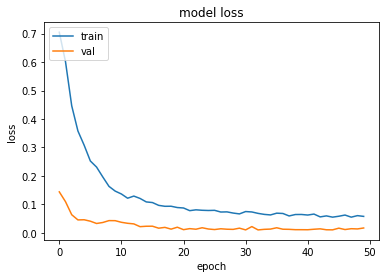

In [ ]:
from matplotlib import pyplot as plt
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [ ]:
y_pred2 = modelC2.predict(x_test)

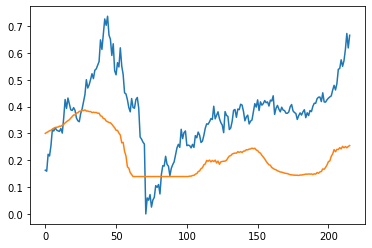

In [ ]:
import matplotlib.pyplot as plt
plt.plot(y_test[:,0])
plt.plot(y_pred2[:,0])

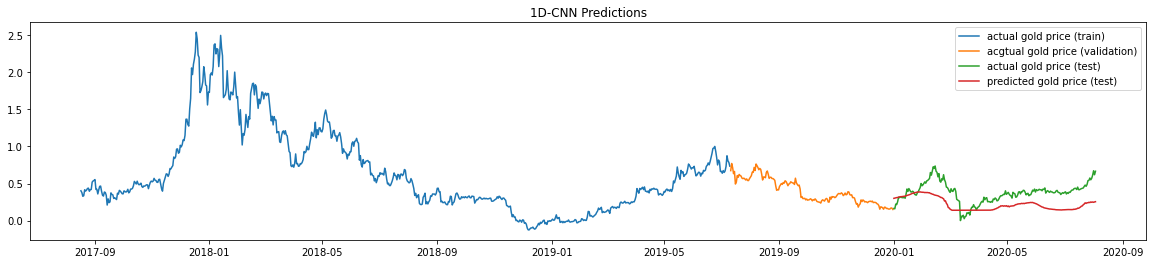

In [ ]:
import matplotlib.pyplot as plt
plt.figure(figsize=(20,4))
plt.plot(pd.date_range(start="2017-08-17",end="2020-09-03")[:693], y_train[:, 0])
plt.plot(pd.date_range(start="2017-08-17",end="2020-09-03")[693: 867], y_valid[:, 0])
plt.plot(pd.date_range(start="2017-08-17",end="2020-09-03")[867: 1083], y_test[:,0])
plt.plot(pd.date_range(start="2017-08-17",end="2020-09-03")[867: 1083], y_pred2[:,0])
plt.legend(['actual gold price (train)', 'acgtual gold price (validation)', 'actual gold price (test)', 'predicted gold price (test)'])
plt.title("1D-CNN Predictions")
plt.show()

In [ ]:
modelC2.save('/content/gdrive/My Drive/crypto_1dcnn')

INFO:tensorflow:Assets written to: /content/gdrive/My Drive/crypto_1dcnn/assets


In [ ]:
from keras.optimizers import Optimizer
from keras import backend as K
import numpy as np

from keras.layers import Input, Dense
from keras.models import Model

def rfit_init(x, y):
  inputs = Input(shape=(1,))
  preds = Dense(1,activation='linear')(inputs)
  model = Model(inputs=inputs,outputs=preds)
  sgd = tfk.optimizers.SGD()
  model.compile(optimizer=sgd ,loss='mse',metrics=['mse'])
  model.fit(x,y, batch_size=1, epochs=30, shuffle=False)
  coef = model.get_weights()
  return coef

class DGLM(Optimizer):
  def __init__(self, lr=0.01, momentum=0., decay=0.,
                 nesterov=False, batch_size, **kwargs):
    super(DGLM, self).__init__(**kwargs)

    self.batch_size = batch_size
    a0 = np.random.uniform(1.0, 1.5, size=(self.batch_size,))
    b0 = np.random.uniform(1.0, 1.5, size=(self.batch_size,))
    zvar = np.random.uniform(0.0, 1.0, size=(self.batch_size,))
    with K.name_scope(self.__class__.__name__):
        self.iterations = K.variable(0, dtype='int64', name='iterations')
        self.lr = K.variable(lr, name='lr')
        self.momentum = K.variable(momentum, name='momentum')
        self.decay = K.variable(decay, name='decay')
    self.initial_decay = decay
    self.nesterov = nesterov

  def _create_slots(self, var_list):
    """For each model variable, create the optimizer variable associated with it.
    TensorFlow calls these optimizer variables "slots".
    For momentum optimization, we need one momentum slot per model variable.
    """
    for var in var_list:
        self.add_slot(var, "mean") # mean
    for var in var_list:
        self.add_slot(var, "variance") # varian

  def get_updates(self, params, loss):

    self.updates = [K.update_add(self.iterations, 1)]
    grads = self.get_gradients(loss, params)

    # learning rate
    lr = self.lr
    if self.initial_decay > 0:
        lr = lr * (1. / (1. + self.decay * K.cast(self.iterations,
                                                  K.dtype(self.decay))))
    # momentum
    shapes = [K.int_shape(p) for p in params]
    moments = [K.zeros(shape) for shape in shapes]
    self.weights = [self.iterations] + moments

    for p, g, m in zip(params, grads, moments):

      v = self.momentum * m - lr * g  # velocity
      self.updates.append(K.update(m, v))

      if self.nesterov:
          new_p = p + self.momentum * v - lr * g
      else:
          new_p = p + v

      new_variance = 

      self.updates.append(K.update(gsi, grad_sum_update))
      self.updates.append(K.update(gns, grad_norm_sum_update))
      self.updates.append(K.update(li, l_update))
      self.updates.append(K.update(ri, reward_update))
      self.updates.append(K.update(p, param_update))
      self.updates.append(K.update(twi, tilde_w_update))
      return self.updates

  def get_config(self):
    config = {'alpha': float(K.get_value(self._alpha)) }
    base_config = super(COCOB, self).get_config()
    return dict(list(base_config.items()) + list(config.items()))

In [ ]:
from keras.optimizers import Optimizer
from keras.legacy import interfaces
from keras import backend as K
import tensorflow as tf

class DGLMoptimizer2(Optimizer):
  
    def __init__(self, lr=0.01, **kwargs):
        super().__init__(**kwargs)
        with K.name_scope(self.__class__.__name__):
            self.iterations = K.variable(0, dtype='int64', name='iterations')
            #self.lr = K.variable(lr, name='lr')
            # self.momentum = K.variable(momentum, name='momentum')
            # self.decay = K.variable(decay, name='decay')
        # self.initial_decay = decay
        # self.nesterov = nesterov

    @interfaces.legacy_get_updates_support
    def get_updates(self, loss, params):
        grads = self.get_gradients(loss, params)
        self.updates = [K.update_add(self.iterations, 1)]

        lr = self.lr
        # if self.initial_decay > 0:
            # lr = lr * (1. / (1. + self.decay * K.cast(self.iterations,
                                                      # K.dtype(self.decay))))
        # momentum
        shapes = [K.int_shape(p) for p in params]
        # moments = [K.zeros(shape) for shape in shapes]
        # p_grads = [K.zeros(shape) for shape in shapes]
        self.weights = [(self.iterations, 1)] #+ moments
        for p, g in zip(params, grads):

            # v = tf.where(past_g*g>0, self.momentum * m - lr * (g + past_g), self.momentum * m - lr * g)  # velocity
            self.updates.append(K.update(m, v))
            self.updates.append(K.update(past_g, g))

            # if self.nesterov:
                # new_p = p + self.momentum * v - lr * g
            # else:
                # new_p = p + v

            # Apply constraints.
            if getattr(p, 'constraint', None) is not None:
                new_p = p.constraint(new_p)

            self.updates.append(K.update(p, new_p))
        return self.updates

    def get_config(self):
        config = {'lr': float(K.get_value(self.lr)),
                  'momentum': float(K.get_value(self.momentum)),
                  'decay': float(K.get_value(self.decay)),
                  'nesterov': self.nesterov}
        base_config = super(ASGD, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))

In [ ]:
from scipy.optimize import minimize

class DGLMoptimizer(keras.optimizers.Optimizer):
    def __init__(self, learning_rate=0.01, name="DGLMoptimizer", **kwargs):
        super().__init__(name, **kwargs)
        self._set_hyper("learning_rate", kwargs.get("lr", learning_rate))
    
    def _create_slots(self, var_list):
        for var in var_list:
            self.add_slot(var, "mean") # mean
            self.add_slot(var, "variance") # variance
            self.add_slot(var, "x") # input data
            self.add_slot(var, "y") # output data
            self.add_slot(var, "z") # z variable

    def link(x, b):
        return exp(np.dot(x, b))

    def Vobj(w, x, y):
        pass

    def G_Vobj():
        pass

    def Wobj():
        pass

    def G_Wobj(b, w, x, y, vr):
        residual = y - link(x, b) / K.sqrt(vr)
        ranks = residual.argsort().argsort() + 1
        rk = ranks/(1+residual.shape[0]) - 0.5
        wdr = (-w*rk*link(x, b))/K.sqrt(vr)
        gr = apply(x, 2, function(u) )

    @tf.function
    def get_updates(self, params, grads):

        zs = []
        variance_params = []
        variance_grads = []
        w = []

        # how to represent x and y in this setting?
        
        for p, g, vp, vg, z, y_e, v_e  in zip(params, grads, variance_params, varaince_grads, zs, y_est, v_est):
          
          # step 1: update variance parameters
          vp = minimize(method = 'BFGS', func=Vobj, jac = G_Vobj, w=w, x=x, y=z)
          v_e = np.dot(x, vp)

          # step 2: update mean parameterrs
          p = minimize(method = 'BFGS', func=Wobj, jac = G_Wobj, w=w, x=x, y=y, vr=v_e)
          y_e = np.dot(x, p)

          new_g
          new_vg

          # step 3: 
          new_z = (y - link(x, y_e))^2
         
          self.updates.append(K.update(p, p))
          self.updates.append(K.update(g, new_g))
          self.updates.append(K.update(vp, vp))
          self.updates.append(K.update(vg, new_vg))
          self.updates.append(K.update(z, z))
          self.updates.append(K.update(v_e, v_e))
          self.updates.append(K.update(y_e, y_e))


    def _resource_apply_sparse(self, grad, var):
        raise NotImplementedError

    def get_config(self):
        base_config = super().get_config()
        return {
            **base_config,
            "learning_rate": self._serialize_hyperparameter("learning_rate"),
        }


SyntaxError: ignored

## LSTM

In [ ]:
modelC3 = Sequential()
modelC3.add(LSTM(128, input_shape=(30, 8)))
modelC3.add(Dropout(0.2))
modelC3.add(Dense(50, activation='relu')) 
modelC3.add(Dropout(0.2))
modelC3.add(Dense(30, activation='relu'))
modelC3.summary()

# compile the model
modelC3.compile(loss=dglm_loss(), optimizer=DGLMOpimizer()) # use the loss defined in DGLM (why use dglm as loss: diverging parameters, controlling 2 things for crypto)

# train the model
checkpointer = ModelCheckpoint(filepath='LSTM.weights.best.hdf5', verbose=1, 
                               save_best_only=True)

hist = modelC3.fit(x_train, y_train, batch_size=64, epochs=50,
          validation_data=(x_valid, y_valid), callbacks=[checkpointer], 
          verbose=1, shuffle=True)

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 128)               70144     
_________________________________________________________________
dropout_34 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_18 (Dense)             (None, 50)                6450      
_________________________________________________________________
dropout_35 (Dropout)         (None, 50)                0         
_________________________________________________________________
dense_19 (Dense)             (None, 30)                1530      
Total params: 78,124
Trainable params: 78,124
Non-trainable params: 0
_________________________________________________________________
Epoch 1/50
11/11 [==============================] - 3s 101ms/step - loss: 0.5032 - val_loss: 0.0555

Epoch 00001: va

In [ ]:
import keras.backend as K
import numpy as np

# def _log_link(x, b):
#   '''
#   The inverse of the log link function.
#   '''
#   X = K.variable(value=x)
#   B = K.variable(value=b)
#   z = K.dot(X,B)
#   y_pred = K.exp(z)
#   return y_pred

def dglm_mean_loss(w, vr): 
  '''
  The objective function. 'WlObj1'
  vr = weights for the variance estimate
  '''
  def _loss(y_true, y_pred):
    y_pred = K.exp(y_pred) # inverse of log link
    residual = (y_true - y_pred) / K.sqrt(vr)
    ranks = residual.argsort().argsort() + 1
    rk = ranks/(1+residual.shape[0]) - 0.5
    obj = sum(w*rk*residual) / residual.shape[0] 
    return obj

  return _loss


def dglm_var_loss(w, y_pred0): 
  '''
  The objective function. 'VlObj1'
  y_pred0 = np.dot(x, b0)
  '''
  def _loss(y_true, y_pred):
    y_pred = K.exp(y_pred) # inverse of log link
    residual = (y_true - y_pred) / K.exp(y_pred0)
    ranks = residual.argsort().argsort() + 1
    rk = ranks/(1+residual.shape[0]) - 0.5
    obj = sum(w*rk*residual) / residual.shape[0] 
    return obj

  return _loss


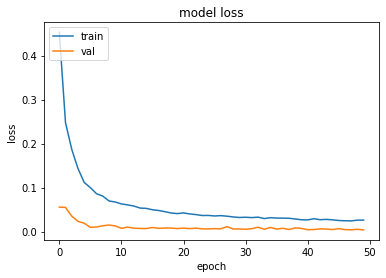

In [ ]:
from matplotlib import pyplot as plt
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [ ]:
y_pred = modelC3.predict(x_test)

In [ ]:
len(y_pred[:,0])

216

In [ ]:
len(y_test[:,0])

216

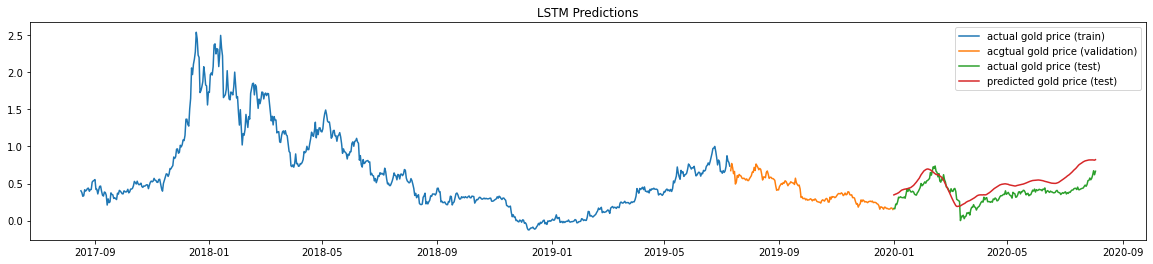

In [ ]:
import matplotlib.pyplot as plt
plt.figure(figsize=(20,4))
plt.plot(pd.date_range(start="2017-08-17",end="2020-09-03")[:693], y_train[:, 0])
plt.plot(pd.date_range(start="2017-08-17",end="2020-09-03")[693: 867], y_valid[:, 0])
plt.plot(pd.date_range(start="2017-08-17",end="2020-09-03")[867: 1083], y_test[:,0])
plt.plot(pd.date_range(start="2017-08-17",end="2020-09-03")[867: 1083], y_pred[:,0])
plt.plot(pd.date_range(start="2017-08-17",end="2020-09-03")[867: 1083], y_pred2[:,0])
plt.legend(['actual gold price (train)', 'acgtual gold price (validation)', 'actual gold price (test)', 'predicted gold price (test)'])
plt.title("LSTM Predictions")
plt.show()

what happens to the prediction if not during a recession?

depending on the weights to each crypto, we know which one is closer to gold/safer. --> differences between cryptocurrencies as safe haven.

In [ ]:
modelC3.save('/content/gdrive/My Drive/crypto_lstm')

INFO:tensorflow:Assets written to: /content/gdrive/My Drive/crypto_lstm/assets


INFO:tensorflow:Assets written to: /content/gdrive/My Drive/crypto_lstm/assets


In [ ]:
for lay in modelC3.layers:
    print(lay.name)
    print(len(lay.get_weights()))

lstm_1
3
dropout_34
0
dense_18
2
dropout_35
0
dense_19
2


LSTM layer

In [ ]:
modelC3.layers[0].get_weights()[0].shape

(8, 512)

In [ ]:
modelC3.layers[0].get_weights()[1].shape

(128, 512)

In [ ]:
modelC3.layers[0].get_weights()[2].shape

(512,)

First Dense layer

In [ ]:
modelC3.layers[2].get_weights()[0].shape

(128, 50)

In [ ]:
modelC3.layers[2].get_weights()[1].shape

(50,)

Second Dense Layer

In [ ]:
modelC3.layers[4].get_weights()[0].shape

(50, 30)

In [ ]:
modelC3.layers[4].get_weights()[1].shape

(30,)

In [ ]:
import numpy as np
a = np.dot(modelC3.layers[0].get_weights()[0], modelC3.layers[0].get_weights()[1].T)
b = np.dot(a, modelC3.layers[2].get_weights()[0])
c = np.dot(b, modelC3.layers[4].get_weights()[0])
daily_allocation = pd.DataFrame(c, index=[e.replace("close_", "") for e in df.columns[1:9]])
daily_allocation

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29
XRP,0.451389,0.670643,0.493214,0.520870,0.462894,0.472937,0.466627,0.728528,0.477966,0.578483,0.563734,0.694166,0.635907,0.652005,0.661889,0.579849,0.704099,0.730196,0.740040,0.805678,0.850066,0.862962,0.782585,0.756937,0.742705,0.783381,0.834204,0.947766,0.874980,0.868085
ETH,0.608185,0.872997,0.595460,0.764815,0.489318,0.542752,0.606181,0.948285,0.792040,0.684494,0.739200,0.734995,0.870189,0.900067,0.799909,0.703395,0.991833,1.073557,1.039434,1.182150,1.256175,1.210731,0.938659,1.221274,1.007908,1.370330,1.268710,1.465080,1.139457,1.183249
LTC,0.100544,0.080561,0.039282,0.066039,0.141838,0.043930,0.086139,0.149182,0.231076,0.269972,0.278599,0.171414,0.201399,0.274700,0.323297,0.281986,0.120201,0.103233,0.275986,0.171142,0.294877,0.281270,0.322869,0.351524,0.380720,0.490521,0.319461,0.511468,0.394095,0.558718
EOS,0.779732,0.836254,0.778243,0.703512,0.543370,0.519737,0.622215,0.854807,0.719130,0.542998,0.661565,0.670270,0.700314,0.697489,0.663331,0.561802,0.833263,0.780392,0.909459,0.885373,0.877557,0.891459,0.634211,0.822232,0.776095,0.897152,0.875491,0.982044,0.820715,0.815351
BCH,0.732778,0.900375,0.749351,0.681123,0.634724,0.490035,0.558559,0.826643,0.633705,0.671080,0.651585,0.634682,0.599796,0.730093,0.707520,0.525020,0.728108,0.742057,0.922807,0.871902,0.836418,0.974718,0.676343,0.929889,0.916816,0.960759,0.944655,1.040915,0.948023,0.875633
BNB,0.212663,0.285257,0.182914,0.236269,0.080991,0.168977,0.160228,0.230606,0.321629,0.196528,0.217605,0.278660,0.370429,0.210161,0.257022,0.288019,0.363497,0.424053,0.402745,0.331950,0.424286,0.402719,0.394565,0.517940,0.370068,0.621334,0.444606,0.616015,0.503118,0.466603
BTC,0.664613,0.758348,0.502155,0.587653,0.556071,0.492625,0.471034,0.719287,0.836422,0.854037,0.713463,0.575067,0.725066,0.813288,0.721820,0.534085,0.618563,0.844899,1.008699,0.746773,0.951320,0.841527,0.868474,0.898097,0.805289,1.277126,0.882779,0.944207,1.030512,1.037712
XMR,0.439318,0.733910,0.526682,0.588086,0.417933,0.302192,0.444737,0.892699,0.733273,0.663497,0.689925,0.767292,0.751743,0.795319,0.891733,0.748480,0.993556,1.030453,1.287565,1.213946,1.273223,1.328327,1.218792,1.451326,1.348484,1.621115,1.465782,1.726110,1.578994,1.475972


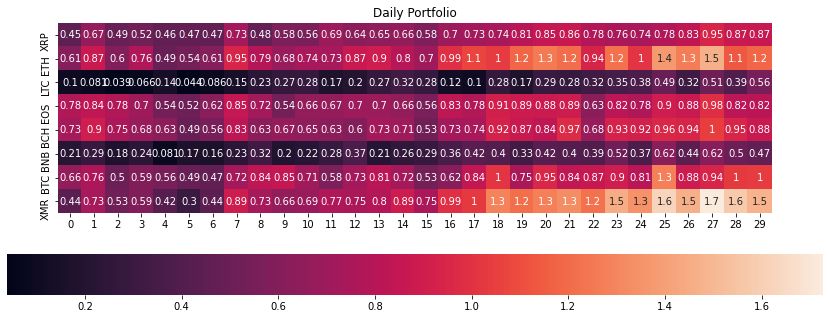

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(20,5)) 
sns.heatmap(daily_allocation, annot=True, square = True, cbar_kws = dict(use_gridspec=False,location="bottom"))
plt.title("Daily Portfolio")
plt.show()

In [ ]:
daily_allocation.to_csv("/content/gdrive/My Drive/crypto_daily_allocation.csv")

In [ ]:

dataset_path = tfk.utils.get_file("auto-mpg.data", "http://archive.ics.uci.edu/ml/machine-learning-databases/auto-mpg/auto-mpg.data")
column_names = ['MPG','Cylinders','Displacement','Horsepower','Weight',
                'Acceleration', 'Model Year', 'Origin']
raw_dataset = pd.read_csv(dataset_path, names=column_names,
                      na_values = "?", comment='\t',
                      sep=" ", skipinitialspace=True)
dataset = raw_dataset.copy()
dataset = dataset.dropna()
origin = dataset.pop('Origin')
dataset['USA'] = (origin == 1)*1.0
dataset['Europe'] = (origin == 2)*1.0
dataset['Japan'] = (origin == 3)*1.0
dataset

32768/30286 [================================] - 0s 4us/step


,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,USA,Europe,Japan
0,18.0,8,307.0,130.0,3504.0,12.0,70,1.0,0.0,0.0
1,15.0,8,350.0,165.0,3693.0,11.5,70,1.0,0.0,0.0
2,18.0,8,318.0,150.0,3436.0,11.0,70,1.0,0.0,0.0
3,16.0,8,304.0,150.0,3433.0,12.0,70,1.0,0.0,0.0
4,17.0,8,302.0,140.0,3449.0,10.5,70,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...
393,27.0,4,140.0,86.0,2790.0,15.6,82,1.0,0.0,0.0
394,44.0,4,97.0,52.0,2130.0,24.6,82,0.0,1.0,0.0
395,32.0,4,135.0,84.0,2295.0,11.6,82,1.0,0.0,0.0
396,28.0,4,120.0,79.0,2625.0,18.6,82,1.0,0.0,0.0


In [ ]:
train_dataset = dataset.sample(frac=0.8,random_state=0)
test_dataset = dataset.drop(train_dataset.index)
mean_dataset = train_dataset.sample(frac=0.5 , random_state=0)
var_dataset = train_dataset.drop(mean_dataset.index)
print(train_dataset.shape, test_dataset.shape, mean_dataset.shape, var_dataset.shape)

(314, 10) (78, 10) (157, 10) (157, 10)


In [ ]:
train_stats = train_dataset.describe()
train_stats.pop("MPG")
train_stats.transpose()
def norm(x):
    return (x - train_stats.loc['mean'])/ train_stats.loc['std']
normed_train_data = norm(train_dataset)
normed_mean_data = norm(mean_dataset)
normed_var_data = norm(var_dataset)
normed_test_data = norm(test_dataset)
train_labels = train_dataset.pop('MPG')
mean_labels = mean_dataset.pop('MPG')
var_labels = var_dataset.pop('MPG')
test_labels = test_dataset.pop('MPG')

In [ ]:
normed_train_data.drop(['MPG'], axis=1, inplace=True)
normed_mean_data.drop(['MPG'], axis=1, inplace=True)
normed_var_data.drop(['MPG'], axis=1, inplace=True)
normed_test_data.drop(['MPG'], axis=1, inplace=True)

In [ ]:
from keras.models import Model
from keras.layers import Input, Dense, Dropout
dropout_rate = 0.5
def model_fn():
    inputs = Input(shape=(9,))
    x = Dense(64, activation='relu')(inputs)
    x = Dropout(dropout_rate)(x)
    x = Dense(64, activation='relu')(x)
    x = Dropout(dropout_rate)(x)
    outputs = Dense(1)(x)
    model = Model(inputs, outputs)
    return model
mean_model = model_fn()
mean_model.compile(loss="mean_squared_error", optimizer='adam')
var_model = model_fn()
var_model.compile(loss="mean_squared_error", optimizer='adam')

In [ ]:
import statistics 
  
# Creating a sample of data 
sample = [2.74, 1.23, 2.63, 2.22, 3, 1.98] 
  
# Prints variance of the sample set 
  
# Function will automatically calculate 
# it's mean and set it as xbar 
print("Variance of sample set is % s" 
      %(statistics.variance(sample))) 

Variance of sample set is 0.40924


In [ ]:
import numpy as np

def rank_based_dispersion_wilcoxon(y_true, y_pred, w, vr): 
  sse = (y_true - y_pred)^2
  y_pred = np.exp(y_pred) # inverse of log link
  residual = (y_true - y_pred) / np.sqrt(vr)
  ranks = residual.argsort().argsort() + 1
  rk = ranks/(1+residual.shape[0]) - 0.5
  disperson = sum(w*rk*residual) / residual.shape[0] 
  return dispersion

In [ ]:
EPOCHS = 100
mean_model.fit(normed_mean_data, mean_labels, epochs=EPOCHS, validation_split=0.2, verbose=0)
mean_predictions = mean_model.predict(normed_var_data)
squared_residuals = (var_labels.values.reshape(-1,1) - mean_predictions) ** 2
var_model.fit(normed_var_data, squared_residuals, epochs=EPOCHS, validation_split=0.2, verbose=0) # use DGLM dispersion measure instead of squared residuals

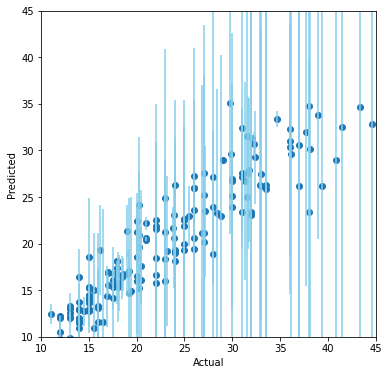

In [ ]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(6,6))
plt.scatter(var_labels,mean_predictions)
plt.ylim([10,45])
plt.xlim([10,45])
plt.xlabel("Actual")
plt.ylabel("Predicted")
for i in range(len(var_labels)):
  low = mean_predictions[i] - squared_residuals[i]/2
  high = mean_predictions[i] + squared_residuals[i]/2
  x = var_labels.tolist()[i]
  plt.vlines(x=x, ymin=low, ymax=high, color='skyblue', zorder=2)

In [ ]:
import keras.backend as K
def tilted_loss(q,y,f):
    e = (y-f)
    return K.mean(K.maximum(q*e, (q-1)*e), axis=-1)
model = model_fn()
model.compile(loss=lambda y,f: tilted_loss(0.5,y,f), optimizer='adam')
lowerq_model = model_fn()
lowerq_model.compile(loss=lambda y,f: tilted_loss(0.025,y,f), optimizer='adam')
upperq_model = model_fn()
upperq_model.compile(loss=lambda y,f: tilted_loss(0.9725,y,f), optimizer='adam')

In [ ]:
lowerq_model.fit(normed_mean_data, mean_labels, epochs=EPOCHS, validation_split=0.2, verbose=0)
upperq_model.fit(normed_mean_data, mean_labels, epochs=EPOCHS, validation_split=0.2, verbose=0)

In [ ]:
lower_pred = lowerq_model.predict(normed_var_data)
upper_pred = upperq_model.predict(normed_var_data)

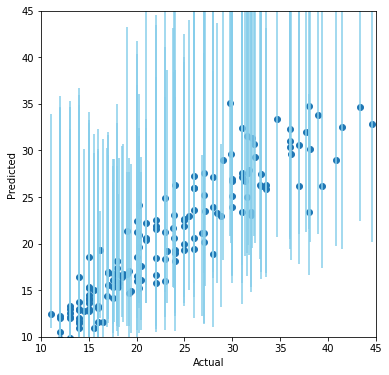

In [ ]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(6,6))
plt.scatter(var_labels,mean_predictions)
plt.ylim([10,45])
plt.xlim([10,45])
plt.xlabel("Actual")
plt.ylabel("Predicted")
for i in range(len(var_labels)):
  low = lower_pred[i]
  high = upper_pred[i]
  x = var_labels.tolist()[i]
  plt.vlines(x=x, ymin=low, ymax=high, color='skyblue', zorder=2)